In [3]:
#based on https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html

import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
MIN_MATCH_COUNT = 10
img1 = cv.imread('box.png', cv.IMREAD_GRAYSCALE)          # queryImage
img2 = cv.imread('box_in_scene.png', cv.IMREAD_GRAYSCALE) # trainImage
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
#Now we set a condition that at least 10 matches (defined by MIN_MATCH_COUNT) are to be there to find the object. Otherwise simply show a message saying not enough matches are present.

#If enough matches are found, we extract the locations of matched keypoints in both the images. They are passed to find the perspective transformation. Once we get this 3x3 transformation matrix, we use it to transform the corners of queryImage to corresponding points in trainImage. Then we draw it.

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

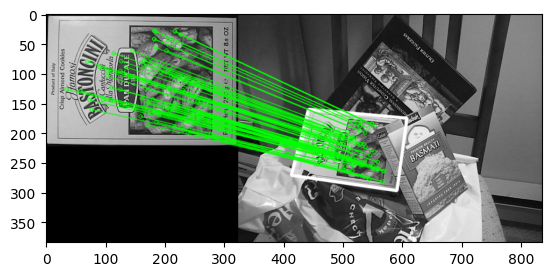

(<matplotlib.image.AxesImage at 0x2bbfbff0dd0>, None)

In [4]:
#Finally we draw our inliers (if successfully found the object) or matching keypoints (if failed).

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.imshow(img3, 'gray'),plt.show()
#See the result below. Object is marked in white color in cluttered image: